# Classify Bristol Property Type from Airbnb data

The Bristol Airbnb data set provides several details on Airbnb listings for the city, such as information on the property, reviews and availability. This notebook aims to identify patterns in the data based on the property type they have listed online. The goal is to check whether Airbnb hosts who live in houses, as opposed to other types of property (mainly apartments), use the site in a different manner compared to the rest of the hosts. If they do, they could form a cluster in the data and be recognised (classified).

Such an analysis could be carried out to find important features that make hosts with houses differ from the non-house hosts. Airbnb itself could be interested in such features for marketing purposes.

Another potential use case could be that such an analysis used by some local council to map the type of property for cases where details of the property type is not well defined in local council data.

The details of problem are explained in the following sections, where the data is explored and analysed.

For clarity, the code cells will be commented on in text in the previous text cell.

The next cell imports the several packages needed.

In [1]:
import itertools
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pydotplus

from matplotlib.colors import ListedColormap
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, average_precision_score, f1_score, balanced_accuracy_score, roc_auc_score
from IPython.core.interactiveshell import InteractiveShell
from sklearn.externals.six import StringIO  
from IPython.display import Image  

sns.set();
InteractiveShell.ast_node_interactivity = "all"
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Data Exploration

This chapter is aimed at exploring the data set, its features, distributions and data types. Errors and outliers would be detected and removed in this chapter. The CSV file is read, the .shape output shows 2375 rows, 28 columns.

In [2]:
df = pd.read_csv("BristolAirbnbListings.csv")
df.shape

(2375, 28)

Some of the data types of the column look wrong. After inspection, errors in the data had produced NaN values for columns expected to be numeric. .dtypes provides an easy way of detecting what columns to target for data cleansing.

In [3]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood                      object
postcode                           object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                       object
bathrooms                          object
bedrooms                           object
beds                               object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
review_scores_rating               object
review_scores_accuracy             object
review_scores_cleanliness          object
review_scores_checkin              object
review_scores_communication       

In [4]:
total_cols = df.columns

Two versions of the data frame were created:
- One that removed all review-score-related columns (excluding reviews_per_month), mainly for the fact that most review scores seemed to be on the high side, and could just slow computation without providing much value.
- The other version includes all review-score-related columns for classification

The version of the data frame that removes review scores:

In [5]:
# df = df[["neighbourhood", "property_type", "room_type", "accommodates", "latitude", "longitude",
#           "bathrooms", "bedrooms", "beds", "price", "minimum_nights", "number_of_reviews",
#          "reviews_per_month", "calculated_host_listings_count", "availability_365"]]
# new_cols = df.columns

Version of the data frame that includes review scores:

In [6]:
df = df.drop(columns=['host_id', 'host_name', 'id', 'last_review', 'name', 'postcode'])
new_cols = df.columns

The following are the columns that have been removed because they provide no extra information for the classification task chosen. Most of them are also categorical features.

In [7]:
set(total_cols) - set(new_cols)

{'host_id', 'host_name', 'id', 'last_review', 'name', 'postcode'}

A check on the room_type shows three features. Rather than One Hot Encoding this column, which would create three separate columns, 'Shared room' and 'Private room' could be merged.

In [8]:
set(df.room_type)

{'Entire home/apt', 'Private room', 'Shared room'}

room_type categories 'Private room' and 'Shared room' are merged, changing the column from 'Room type' to a binary 'Entire home': no if 'Private room' or 'Shared room', yes if the value is 'Entire home/apt'. The column is renamed to 'entire_home'.

In [9]:
df.loc[(df["room_type"] == "Private room") | (df["room_type"] == "Shared room"), 'room_type'] = "no"
df.loc[df["room_type"] == "Entire home/apt", "room_type"] = "yes"
df = df.rename(index=str, columns={"room_type": "entire_home"})

A look on the Bristol neighbourhood shows 34 in total. No errors in this column.

In [10]:
neighbourhoods = set(df.neighbourhood)
neighbourhoods

{'Ashley',
 'Avonmouth & Lawrence Weston',
 'Bedminster',
 'Bishopston & Ashley Down',
 'Bishopsworth',
 'Brislington East',
 'Brislington West',
 'Central',
 'Clifton',
 'Clifton Down',
 'Cotham',
 'Easton',
 'Eastville',
 'Filwood',
 'Frome Vale',
 'Hartcliffe & Withywood',
 'Henbury & Brentry',
 'Hengrove & Whitchurch Park',
 'Hillfields',
 'Horfield',
 'Hotwells & Harbourside',
 'Knowle',
 'Lawrence Hill',
 'Lockleaze',
 'Redland',
 'Southmead',
 'Southville',
 'St George Central',
 'St George Troopers Hill',
 'St George West',
 'Stockwood',
 'Stoke Bishop',
 'Westbury-on-Trym & Henleaze',
 'Windmill Hill'}

The 'entire_home' column is One Hot Encoded, and the result is a new column 'entire_home_yes' that has value 0 for no, 1 for yes. The columns that were displayed as objects and that are expected to be numeric are converted to numeric, with 'coerce' error transforming any non numeric (empty cell included) value to NaN. The output shows how many rows were found for each column. These rows are dropped as information on their features is unknown. 

In [11]:
dummies = pd.get_dummies(df.entire_home, prefix="entire_home")
df = df.drop(columns="entire_home")
df = pd.concat([df, dummies], axis=1)
df = df.drop(columns="entire_home_no")

df.accommodates = pd.to_numeric(df.accommodates, errors='coerce', downcast='signed')
print("NaN accommodates rows:", len(df[df.accommodates.isnull()]))
df = df.dropna(subset=['accommodates'])

df.bathrooms = pd.to_numeric(df.bathrooms, errors='coerce')
print("NaN bathrooms rows:", len(df[df.bathrooms.isnull()]))
df = df.dropna(subset=['bathrooms'])

df.bedrooms = pd.to_numeric(df.bedrooms, errors='coerce', downcast='signed')
print("NaN bedrooms rows:", len(df[df.bedrooms.isnull()]))
df = df.dropna(subset=['bedrooms'])

df.beds = pd.to_numeric(df.beds, errors='coerce', downcast='signed')
print("NaN beds rows:", len(df[df.beds.isnull()]))
df = df.dropna(subset=['beds'])

NaN accommodates rows: 22
NaN bathrooms rows: 3
NaN bedrooms rows: 3
NaN beds rows: 2


The next cell outputs the list of property types throughout the data set. No errors seem to be found, although the number of property types is long, and some of them could be grouped together in a rationale manner. This will be carried out in the following section.

In [12]:
set(df.property_type)

{'Apartment',
 'Barn',
 'Bed and breakfast',
 'Boat',
 'Boutique hotel',
 'Bungalow',
 'Cabin',
 'Camper/RV',
 'Casa particular (Cuba)',
 'Condominium',
 'Cottage',
 'Farm stay',
 'Guest suite',
 'Guesthouse',
 'Hostel',
 'Hotel',
 'House',
 'Hut',
 'Loft',
 'Other',
 'Serviced apartment',
 "Shepherd's hut (U.K., France)",
 'Tent',
 'Tiny house',
 'Townhouse',
 'Villa',
 'Yurt'}

The following cell outputs whether there are NaN values for each column. The review-related columns seem to need cleansing.

In [13]:
df.isnull().any()

neighbourhood                     False
latitude                          False
longitude                         False
property_type                     False
accommodates                      False
bathrooms                         False
bedrooms                          False
beds                              False
price                             False
minimum_nights                    False
number_of_reviews                 False
reviews_per_month                  True
review_scores_rating               True
review_scores_accuracy             True
review_scores_cleanliness          True
review_scores_checkin              True
review_scores_communication        True
review_scores_location             True
review_scores_value                True
calculated_host_listings_count    False
availability_365                  False
entire_home_yes                   False
dtype: bool

The next cell goes through the review columns in order to bring the NaN rows to 0. The output of the length for NaN review_per_month rows is 304. This is high as it could be that they are empty cells since there are no reviews yet for that listing. The next output, 301, confirms this. A decision is then made to assign 0 to reviews_per_month rows that have no reviews, and drop the 3 remaining rows.

The same check is performed on review scores. The review score rows with NaNs are then converted to numeric, and their length printed.

In [14]:
print(len(df[df.reviews_per_month.isnull()]))
print(len(df.loc[(df.reviews_per_month.isnull()) & (df.number_of_reviews == 0), 'reviews_per_month']))
df.loc[(df.reviews_per_month.isnull()) & (df.number_of_reviews == 0), 'reviews_per_month'] = 0
df = df.dropna(subset=['reviews_per_month'])

print(len(df[df.review_scores_rating.isnull()]))
print(len(df.loc[(df.review_scores_rating.isnull()) & (df.number_of_reviews == 0), 'reviews_per_month']))

df.review_scores_rating = pd.to_numeric(df.review_scores_rating, errors='coerce')
df.review_scores_accuracy = pd.to_numeric(df.review_scores_accuracy, errors='coerce')
df.review_scores_cleanliness = pd.to_numeric(df.review_scores_cleanliness, errors='coerce')
df.review_scores_checkin = pd.to_numeric(df.review_scores_checkin, errors='coerce')
df.review_scores_communication = pd.to_numeric(df.review_scores_communication, errors='coerce')
df.review_scores_location = pd.to_numeric(df.review_scores_location, errors='coerce')
df.review_scores_value = pd.to_numeric(df.review_scores_value, errors='coerce')

print(len(df[df.review_scores_rating.isnull()]))
print(len(df[df.review_scores_accuracy.isnull()]))
print(len(df[df.review_scores_cleanliness.isnull()]))
print(len(df[df.review_scores_checkin.isnull()]))
print(len(df[df.review_scores_communication.isnull()]))
print(len(df[df.review_scores_location.isnull()]))
print(len(df[df.review_scores_value.isnull()]))

304
301
331
301
331
332
332
334
332
334
334


### Data Cleansing for data frame with Review scores
#### NaN Resolving Approaches
1. Fill Review Scores with zeros, for listings that have zero reviews, drop rest
2. Fill Review Scores with median value for listings that have zero reviews, drop rest
3. Drop all rows with missing review scores

Approach #1:

In [15]:
df.loc[(df.review_scores_rating.isnull()) & (df.number_of_reviews == 0), 'review_scores_rating'] = 0
df.loc[(df.review_scores_accuracy.isnull()) & (df.number_of_reviews == 0), 'review_scores_accuracy'] = 0
df.loc[(df.review_scores_cleanliness.isnull()) & (df.number_of_reviews == 0), 'review_scores_cleanliness'] = 0
df.loc[(df.review_scores_checkin.isnull()) & (df.number_of_reviews == 0), 'review_scores_checkin'] = 0
df.loc[(df.review_scores_communication.isnull()) & (df.number_of_reviews == 0), 'review_scores_communication'] = 0
df.loc[(df.review_scores_location.isnull()) & (df.number_of_reviews == 0), 'review_scores_location'] = 0
df.loc[(df.review_scores_value.isnull()) & (df.number_of_reviews == 0), 'review_scores_value'] = 0

print(len(df[df.review_scores_rating.isnull()]))
print(len(df[df.review_scores_accuracy.isnull()]))
print(len(df[df.review_scores_cleanliness.isnull()]))
print(len(df[df.review_scores_checkin.isnull()]))
print(len(df[df.review_scores_communication.isnull()]))
print(len(df[df.review_scores_location.isnull()]))
print(len(df[df.review_scores_value.isnull()]))

df = df.dropna(subset=[
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
])

30
31
31
33
31
33
33


As expected, the remaining rows that come from errors are not that many. These can be dropped.

The following approaches have been left in the code but were not performed.

Approach #2:

In [16]:
# df.loc[df.review_scores_rating.isnull(), 'review_scores_rating'] = df.review_scores_rating.median()
# df.loc[df.review_scores_accuracy.isnull(), 'review_scores_accuracy'] = df.review_scores_accuracy.median()
# df.loc[df.review_scores_cleanliness.isnull(), 'review_scores_cleanliness'] = df.review_scores_cleanliness.median()
# df.loc[df.review_scores_checkin.isnull(), 'review_scores_checkin'] = df.review_scores_checkin.median()
# df.loc[df.review_scores_communication.isnull(), 'review_scores_communication'] = df.review_scores_communication.median()
# df.loc[df.review_scores_location.isnull(), 'review_scores_location'] = df.review_scores_location.median()
# df.loc[df.review_scores_value.isnull(), 'review_scores_value'] = df.review_scores_value.median()

Approach #3:

In [17]:
# df = df.dropna(subset=[
#     'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
#     'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
#     'review_scores_value'
# ])

A drop on duplicates is performed in case there are any, and then a check on any null value in the whole data set is carried out, resulting in negative. The new shape shows a slightly trimmed data set. The data types seem to be all correct now.

In [18]:
df = df.drop_duplicates()
df.isnull().any().any()
df.shape
df.dtypes

False

(2309, 22)

neighbourhood                      object
latitude                          float64
longitude                         float64
property_type                      object
accommodates                      float64
bathrooms                         float64
bedrooms                          float64
beds                              float64
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
review_scores_rating              float64
review_scores_accuracy            float64
review_scores_cleanliness         float64
review_scores_checkin             float64
review_scores_communication       float64
review_scores_location            float64
review_scores_value               float64
calculated_host_listings_count      int64
availability_365                    int64
entire_home_yes                     uint8
dtype: object

## Univariate Analysis
Now that the data has been cleansed and every column is free of NaN values, it can be plotted and analysed. Outliers that are not errors would be noticed in this section.

The following plot shows the listings count by property type. As expected, the more 'exotic' property types have only a few listings. Including these in classification would not be fruitful. Some grouping could be done on whether the property type is a house or not, with 'house' including several related property_types.

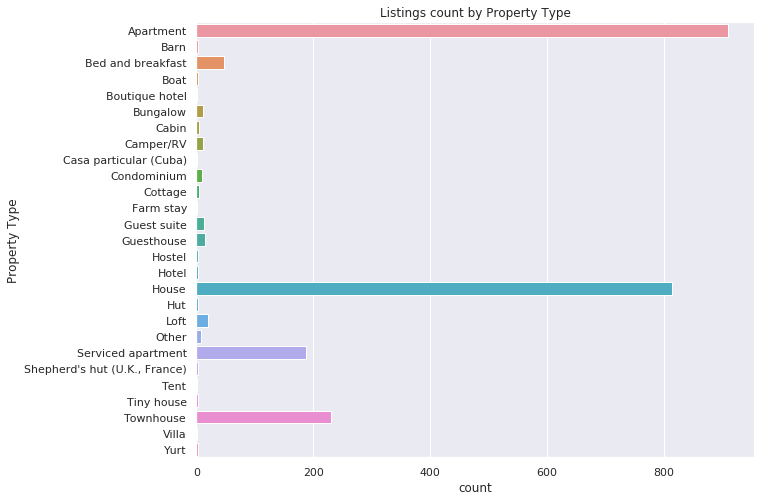

In [19]:
fig = plt.figure(figsize=(10,8))
cnt = Counter(df.property_type.sort_values())
ax = sns.barplot(x=list(cnt.values()), y=list(cnt.keys()))
xlab = plt.xlabel('count')
ylab = plt.ylabel('Property Type')
tit = plt.title("Listings count by Property Type")

The following cell locates property types that could be technically called 'houses'. A new column is created, 'is_house', with 1 for what can be classified as house, 0 for the rest. 

This solution would ease classification while maintaining a realistic goal. Binary classification could be performed, rather than multi label.

In [20]:
df.loc[
    (df.property_type == "Bungalow") |
    (df.property_type == "Casa particular (Cuba)") |
    (df.property_type == "Cottage") |
    (df.property_type == "House") |
    (df.property_type == "Tiny house") |
    (df.property_type == "Townhouse") |
    (df.property_type == "Villa"), 'is_house'    
] = 1
df.loc[df.is_house.isnull(), 'is_house'] = 0

The following bar plot shows the count for the new column. A fairly even split, although as expected there are more 'Not a House' rows.

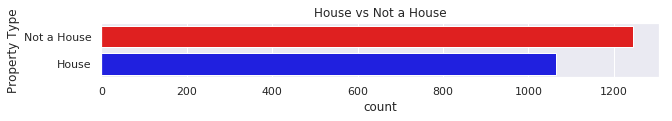

In [21]:
fig = plt.figure(figsize=(10,1))
cnt = Counter(df.is_house.sort_values())
ax = sns.barplot(x=[len(df.loc[df.is_house == 0]),
                    len(df.loc[df.is_house == 1])],
                 y=["Not a House", "House"],
                 palette=["red", "blue"])
xlab = plt.xlabel('count')
ylab = plt.ylabel('Property Type')
tit = plt.title("House vs Not a House")

The following plot checks the count for whether it's a shared listing, or 'entire home/apt'.

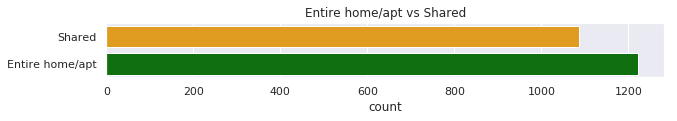

In [22]:
fig = plt.figure(figsize=(10,1))
cnt = Counter(df.entire_home_yes.sort_values())
ax = sns.barplot(x=[len(df.loc[df.entire_home_yes == 0]),
                    len(df.loc[df.entire_home_yes == 1])],
                 y=["Shared", "Entire home/apt"],
                 palette=["orange", "green"])
xlab = plt.xlabel('count')
tit = plt.title("Entire home/apt vs Shared")

The following bar plot shows the count per neighbourhood.

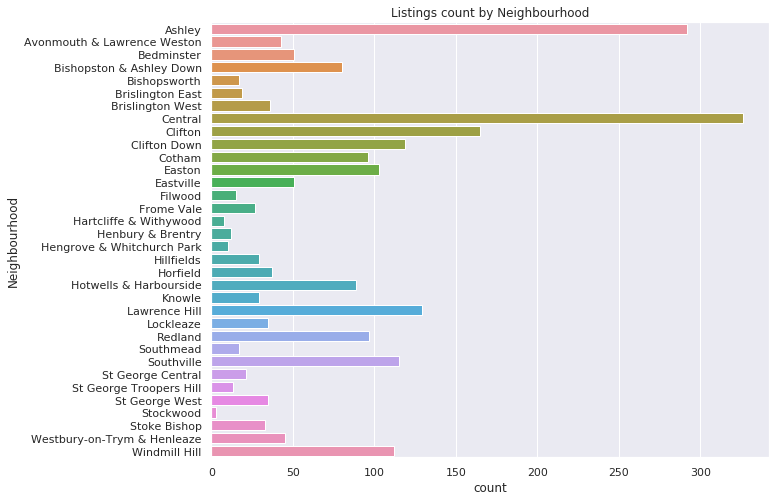

In [23]:
fig = plt.figure(figsize=(10,8))
cnt = Counter(df.neighbourhood.sort_values())
ax = sns.barplot(x=list(cnt.values()), y=list(cnt.keys()))
xlab = plt.xlabel('count')
ylab = plt.ylabel('Neighbourhood')
tit = plt.title("Listings count by Neighbourhood")

Checking to see the distribution for the availability_365 column, plotted with limits as several have 0 as value.

Non-zero availability rows: 1711


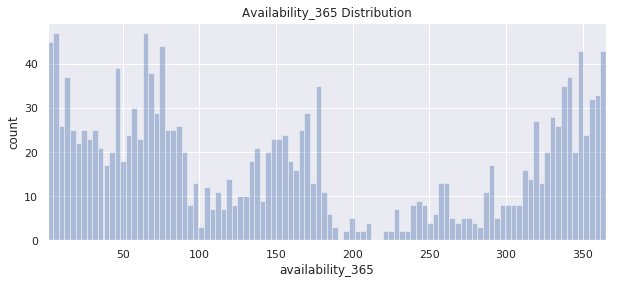

In [24]:
print("Non-zero availability rows:", len(df.loc[df.availability_365 != 0, 'availability_365']))
fig = plt.figure(figsize=(10,4))
dist = sns.distplot(df.loc[df.availability_365 != 0, 'availability_365'], 100, kde=False)
lims = plt.xlim(1, max(df.availability_365))
ylab = plt.ylabel("count")
tit = plt.title("Availability_365 Distribution")

## Multivariate Analysis
The following bar plot shows the percentage of houses in each neighbourhood. As expected, Central and 'trendy' neighbourhoods such as Clifton have a low percentage of houses. The further from the centre, the higher the ratio is.

/home/dtp/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


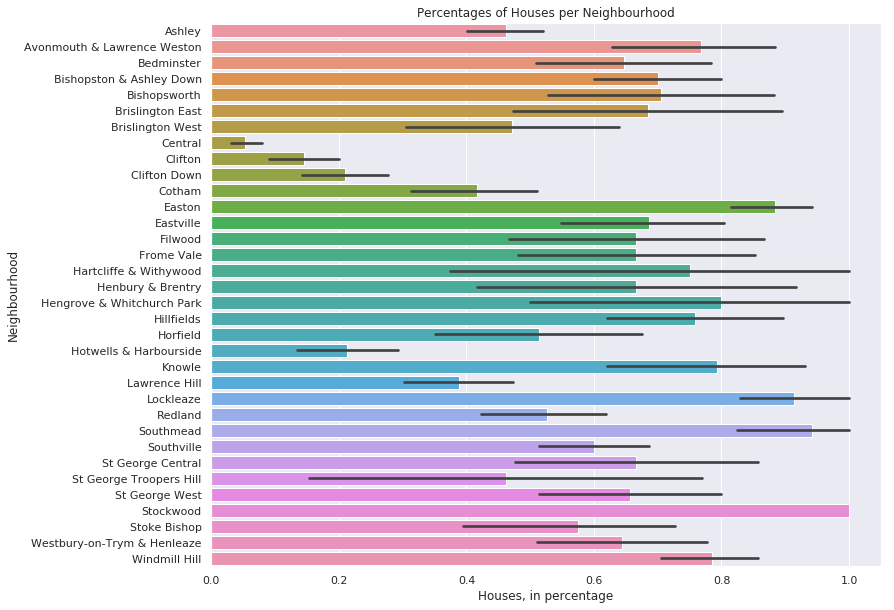

In [25]:
fig = plt.figure(figsize=(12,10))
ax = sns.barplot(x=df.is_house, y=df.neighbourhood.sort_values(), orient='h')
xlab = plt.xlabel('Houses, in percentage')
ylab = plt.ylabel('Neighbourhood')
tit = plt.title("Percentages of Houses per Neighbourhood")

The following box plot tries to locate any particular neighbourhood patterns for availability_365 values. It seems that the further from the centre, the higher the availability.

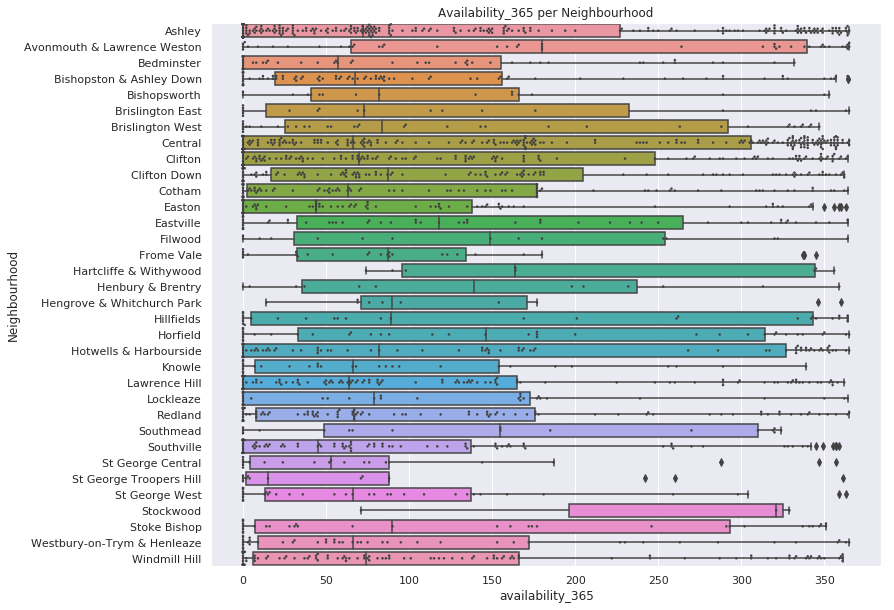

In [26]:
fig = plt.figure(figsize=(12,10))
ax = sns.boxplot(x=df.availability_365, y=df.neighbourhood.sort_values(), orient='h')
ax = sns.swarmplot(x=df.availability_365, y=df.neighbourhood.sort_values(), size=2.5, color=".25")
ylab = plt.ylabel('Neighbourhood')
tit = plt.title("Availability_365 per Neighbourhood")

This box plot shows the listing price per neighbourhood. As expected, the central and inner neighbourhoods have higher prices

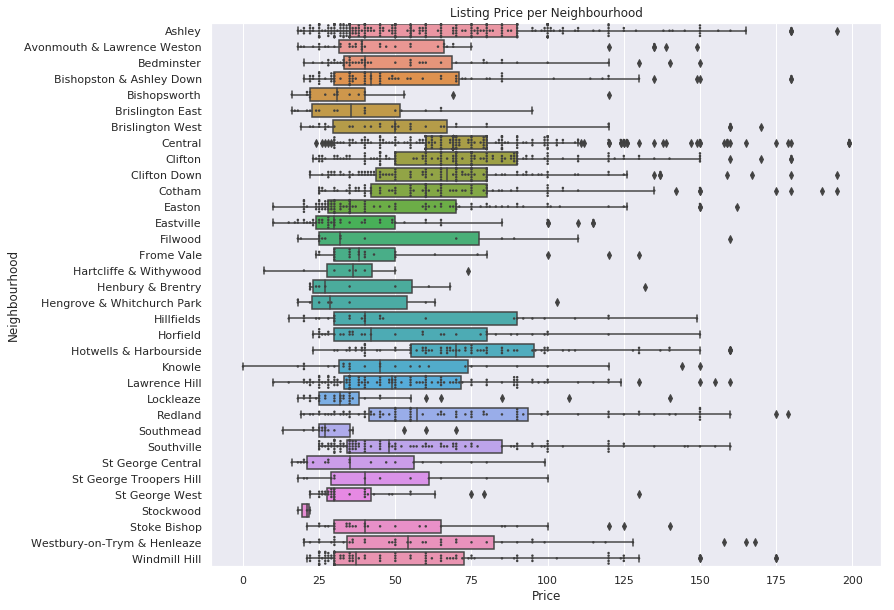

In [27]:
fig = plt.figure(figsize=(12,10))
ax = sns.boxplot(x=df.loc[df.price < 200, 'price'], y=df.neighbourhood.sort_values(), orient='h')
ax = sns.swarmplot(x=df.loc[df.price < 200, 'price'], y=df.neighbourhood.sort_values(), size=2.5, color=".25")
xlab = plt.xlabel('Price')
ylab = plt.ylabel('Neighbourhood')
tit = plt.title("Listing Price per Neighbourhood")

This bar plot shows the listing price per property type. Interestingly, the price tends to be lower for the house cluster. This should be because the majority of Airbnb hosts could be living in apartments in the centre, which would cost more.

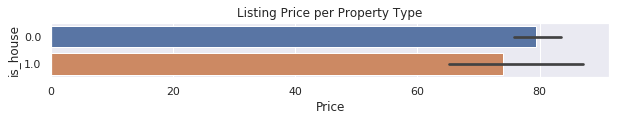

In [28]:
fig = plt.figure(figsize=(10,1))
ax = sns.barplot(x=df.price, y=df.is_house, orient='h')
xlab = plt.xlabel('Price')
tit = plt.title("Listing Price per Property Type")

The following plot could prove what was said earlier: the majority of Airbnb listings are inner city apartments, since the availability is higher for them. Or it could be seen differently, that owners of several properties could be more likely to have a city apartment that they use Airbnb for, for several days a year.

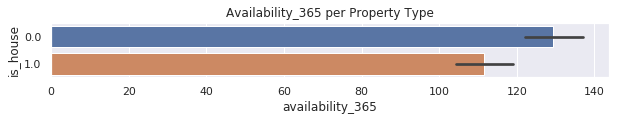

In [29]:
fig = plt.figure(figsize=(10,1))
ax = sns.barplot(x=df.availability_365, y=df.is_house, orient='h')
tit = plt.title("Availability_365 per Property Type")

This figure seems to show that people who live in apartments are a lot more likely to not be staying in the property while the guest is (entire_home_yes = 1), which is interesting.

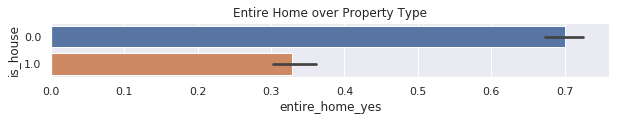

In [30]:
fig = plt.figure(figsize=(10,1))
ax = sns.barplot(x=df.entire_home_yes, y=df.is_house, orient='h')
tit = plt.title("Entire Home over Property Type")

### Distribution and Box Plots - Outlier Detection
Several dataframes are created for the following plots.

In [31]:
df_no_geo = df.drop(columns=["latitude", "longitude"])
df_short = df_no_geo.drop(columns=["neighbourhood", "property_type"])
df_short_no_av = df_short.drop(columns=["availability_365", "entire_home_yes", "is_house"])

The following .describe() command shows several summary statistics. No numerical errors seem to be present.

In [32]:
df_no_geo.describe()

,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,availability_365,entire_home_yes,is_house
count,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000
mean,3.109571,1.240797,1.430056,1.808575,76.903854,2.669554,32.003465,1.938493,82.573408,8.475097,8.319186,8.546124,8.555652,8.314422,8.244695,7.063664,121.158510,0.529233,0.460806
std,2.147636,0.608510,0.982506,1.543055,130.753321,11.127917,51.548752,2.188882,32.567892,3.333942,3.299845,3.349017,3.350425,3.273742,3.273677,16.980359,128.222645,0.499253,0.498569
min,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,35.000000,1.000000,2.000000,0.310000,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,1.000000,59.000000,2.000000,11.000000,1.130000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,71.000000,1.000000,0.000000
75%,4.000000,1.000000,2.000000,2.000000,85.000000,2.000000,38.000000,2.870000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,3.000000,221.000000,1.000000,1.000000
max,16.000000,12.500000,13.000000,24.000000,5000.000000,365.000000,477.000000,18.030000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,78.000000,365.000000,1.000000,1.000000


Several plots to show the distribution of most numerical columns and check for outliers.

In [33]:
def plotHistBox(col):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15,4))
    sns.boxplot(df[col], ax=ax_box)
    sns.distplot(df[col], bins=150, ax=ax_hist, kde=False)
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

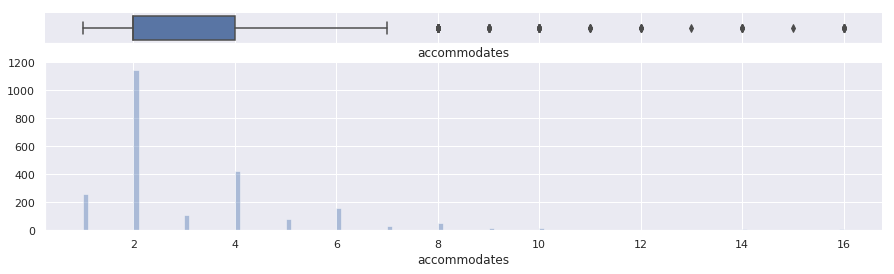

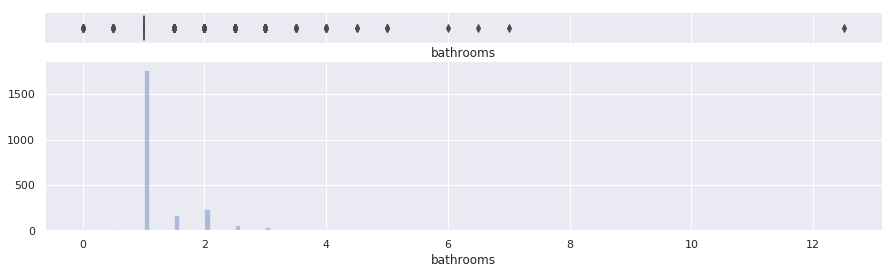

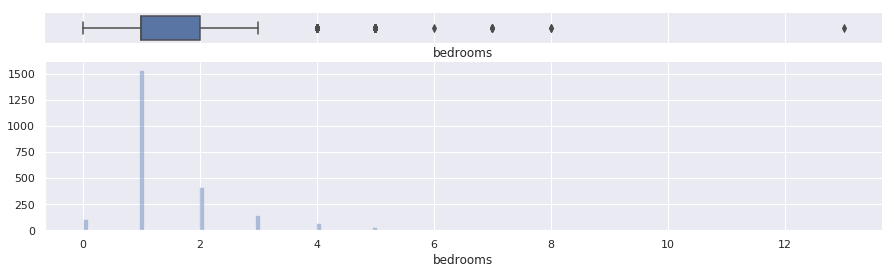

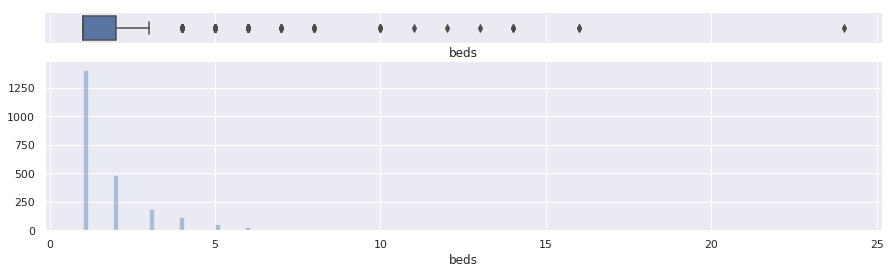

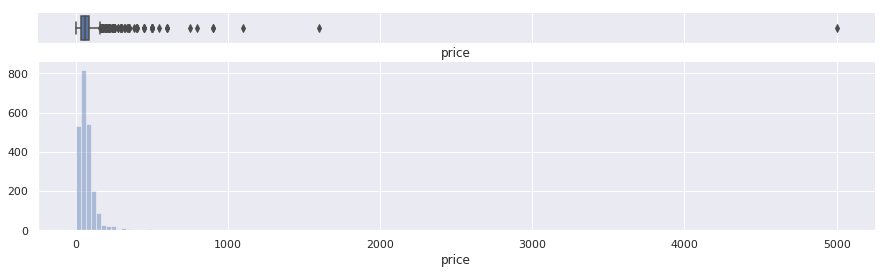

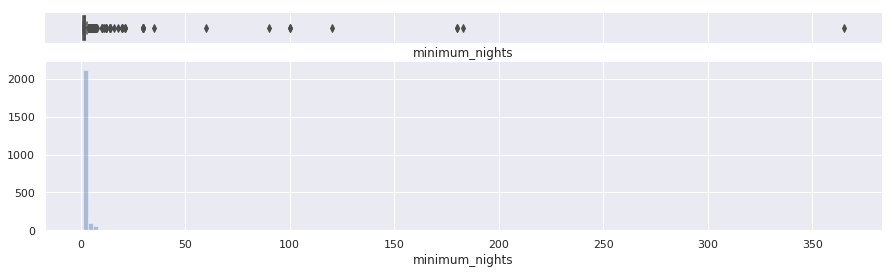

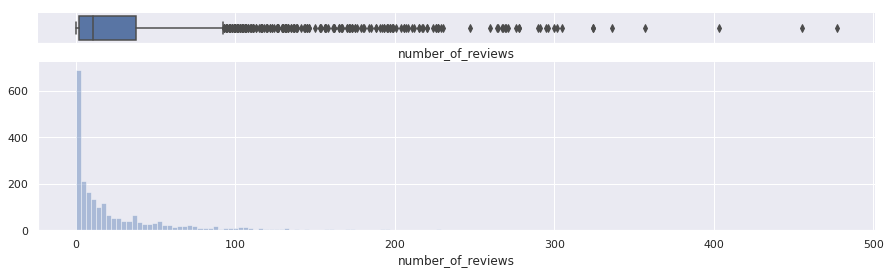

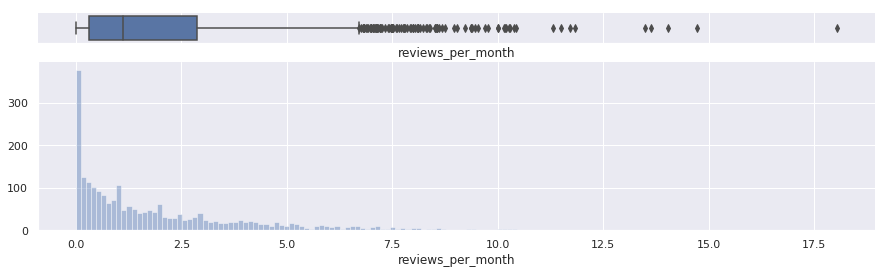

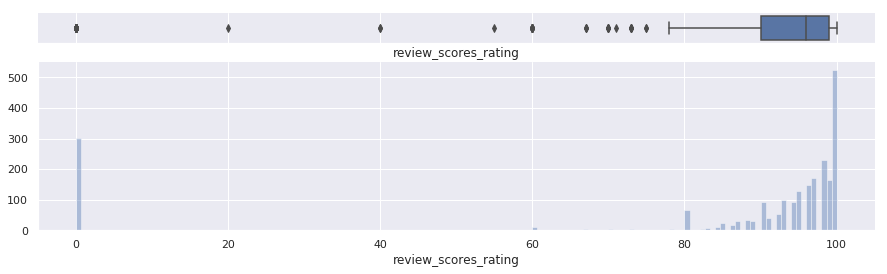

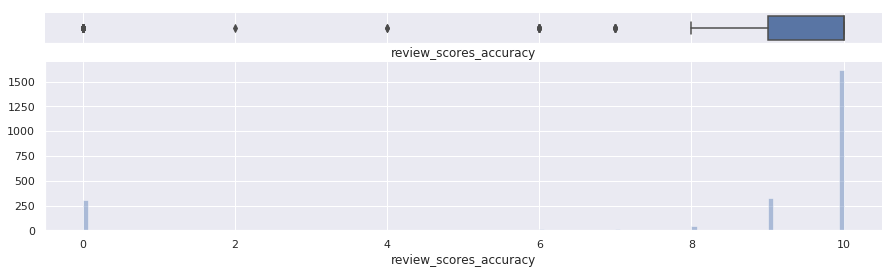

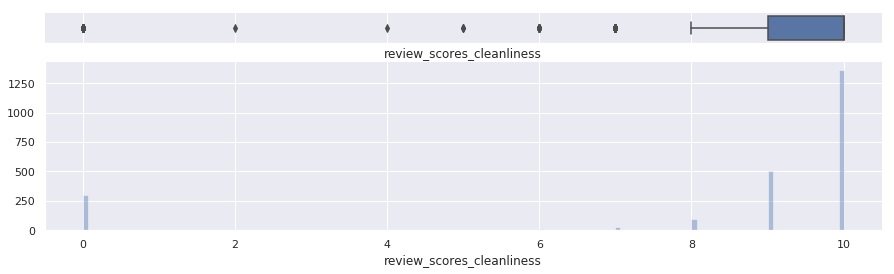

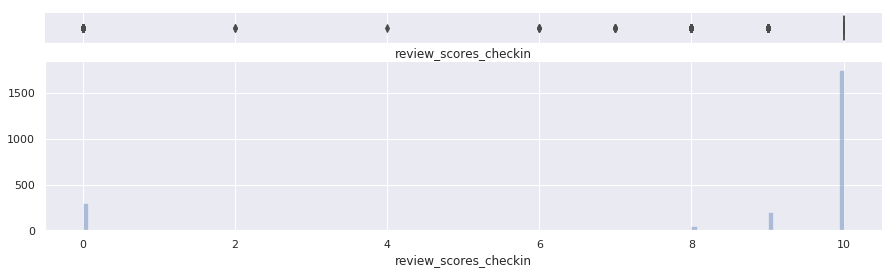

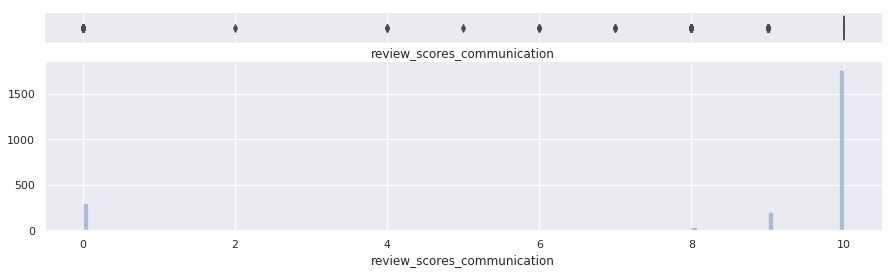

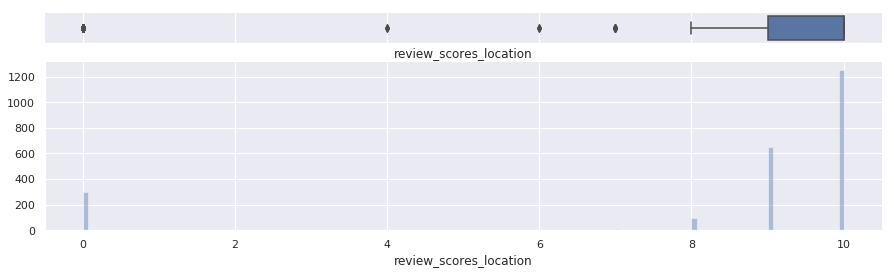

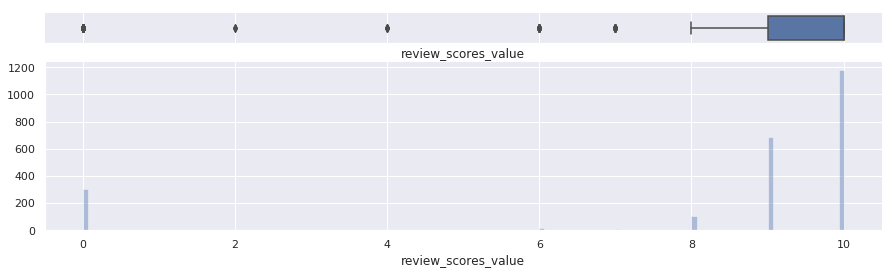

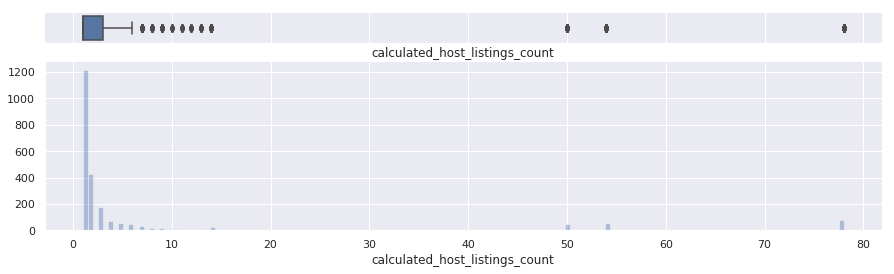

In [34]:
for col in df_short_no_av.columns:
    plotHistBox(col)

### Remove Price Outliers
The price column shows that most values sit below 300. Some values go up to 5000, as shown in the previous plot. The outliers were initially removed in the following cell, but due to the choice of classifiers being based on decision trees, they were left in the data.

In [35]:
# print(len(df.loc[df.price > 300]))
# df = df.loc[df.price < 300]
# plt.figure(figsize=(15,4))
# dp = sns.distplot(df.price, 125, kde=False)

### Heatmap for correlated features
The following heatmap shows the Pearson Correlation Coefficient (PCC) for each numerical feature in the data set.

As expected, all review-related columns are positively correlated with each other. Most property-related features such as bedrooms, beds and bathrooms also are correlated.

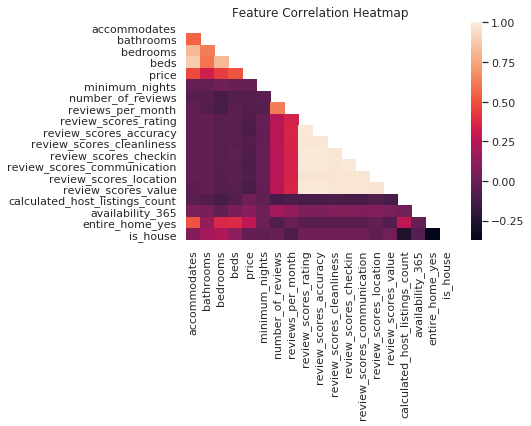

In [36]:
corr = df_short.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask)
tit = plt.title("Feature Correlation Heatmap")

### Map Plots
By using the latitude and longitude columns, and a GeoJSON file of the Bristol map found online, a map plot was created to gather better visualisation of the data. GeoPandas reads the file and creates a dataframe.

The following plot shows the distribution of the listings over Bristol.

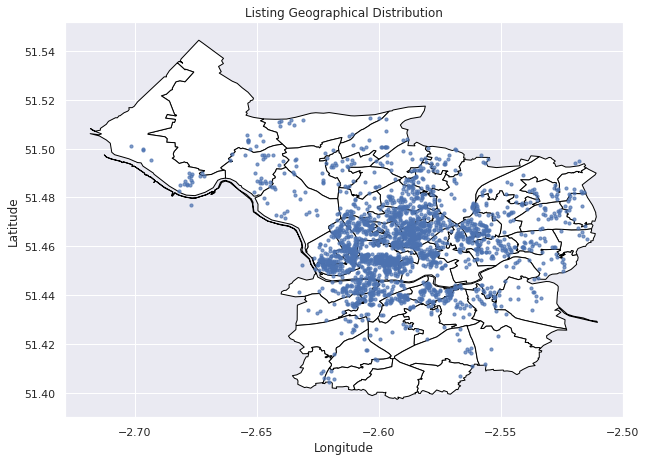

In [37]:
map_json = "map/bristol-polygon.shp"
map_df = gpd.read_file(map_json)
map_plt = map_df.plot(color='white', edgecolor='black', figsize=(10,10))
scatter_map = plt.scatter(df.longitude, df.latitude, s=10, alpha=0.7)
xlab = plt.xlabel("Longitude")
ylab = plt.ylabel("Latitude")
tit = plt.title("Listing Geographical Distribution")

In [38]:
def plotMap(col, ms, alpha, dataframe, title):
    groups = dataframe.groupby(col)
    fig, ax = plt.subplots(figsize=(11.5,11.5))
    ax.set_aspect('equal')

    map_df.plot(ax=ax, color='white', edgecolor='black')
    for name, group in groups:
        plt.scatter(group.longitude, group.latitude, s=ms, alpha=alpha, label=name)
    colormap = plt.cm.gist_ncar
    colorst = [colormap(i) for i in np.linspace(0, 0.9, len(ax.collections))]       
    for t,j1 in enumerate(ax.collections):
        if t > 0:
            j1.set_color(colorst[t])
    xlab = plt.xlabel("Longitude")
    ylab = plt.ylabel("Latitude")
    tit = plt.title(title)
    leg = ax.legend(numpoints=5, bbox_to_anchor=(1.04,1.015))
    
def plotMapBi(col, ms, alpha, dataframe, labels, c, title):
    groups = dataframe.groupby(col)
    fig, ax = plt.subplots(figsize=(11.5,11.5))
    ax.set_aspect('equal')
    mplot = map_df.plot(ax=ax, color='white', edgecolor='black')
    counter = 0
    for name, group in groups:
        counter += 1
        if counter == 1:
            sct1 = plt.scatter(group.longitude, group.latitude, s=ms, alpha=alpha, label=labels[0], c=c[0])
        else:
            sct2 = plt.scatter(group.longitude, group.latitude, s=ms, alpha=alpha, label=labels[1], c=c[1])
    xlab = plt.xlabel("Longitude")
    ylab = plt.ylabel("Latitude")
    tit = plt.title(title)
    leg = ax.legend()

The following plot shows the neighbourhood clusters mapped. This is really useful as it is possible to tell what neighbourhoods are central, as well as information on the area they cover.

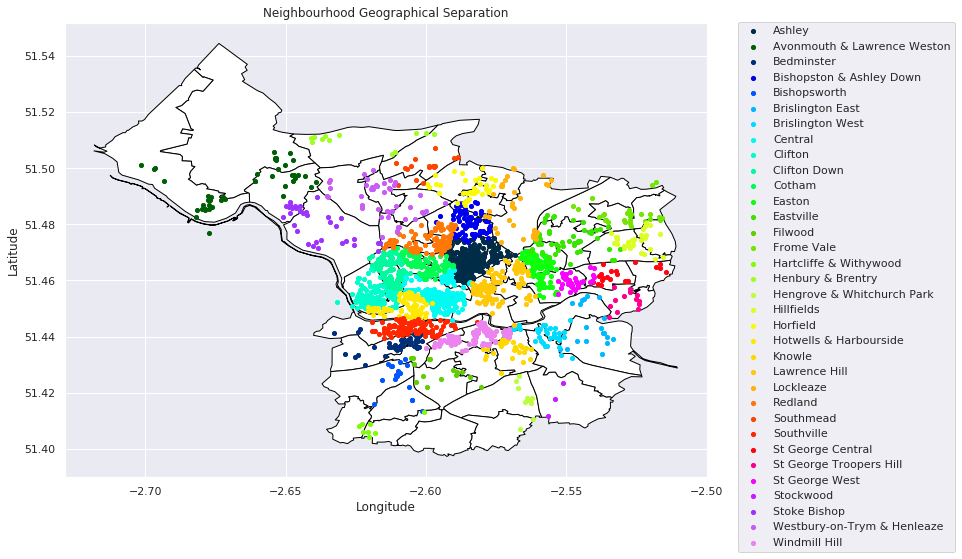

In [39]:
plotMap('neighbourhood', 17, 1, df, "Neighbourhood Geographical Separation")

The next plot shows the listings plotted on the map by their property type, using the original 'property_type' column. As expected, as one gets closer to the centre the number of houses diminishes.

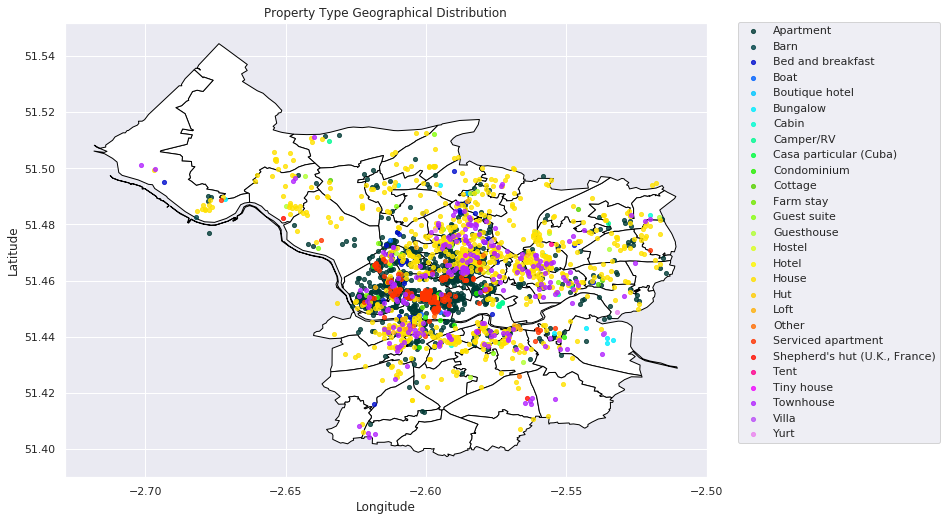

In [40]:
plotMap('property_type', 17, 0.8, df, "Property Type Geographical Distribution")

This plot shows the distribution of shared vs entire home. As stated earlier, as one moves out of the centre hosts are less likely to leave the property entirely to the guest.

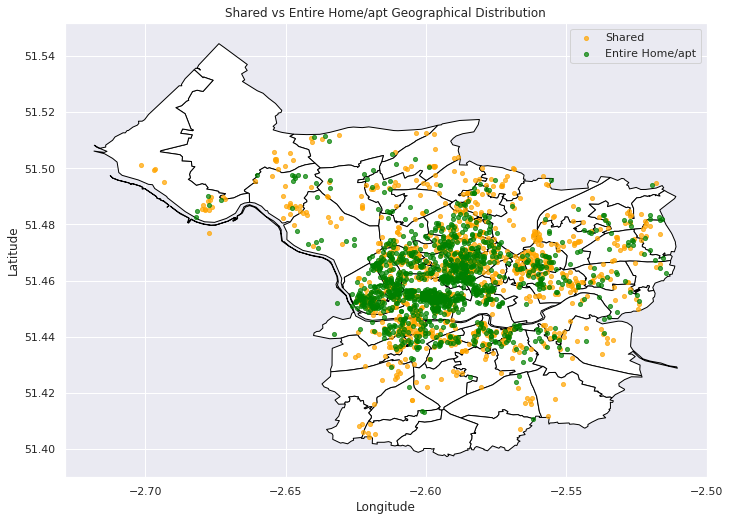

In [41]:
plotMapBi('entire_home_yes', 17, 0.7, df, ["Shared", "Entire Home/apt"],
          ["orange", "green"], "Shared vs Entire Home/apt Geographical Distribution")

This plot shows the property type plotted with the new binary column 'is_house'. This draws a clear picture for the central neighbourhood, although classifying the 'Not a Houses' in the outer areas could prove difficult.

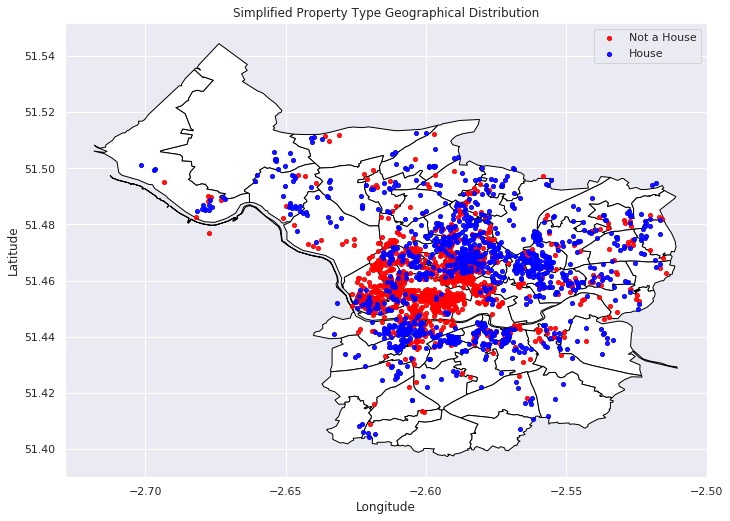

In [42]:
plotMapBi('is_house', 17, 0.9, df, ["Not a House", "House"], ["red", "blue"],
         "Simplified Property Type Geographical Distribution")

The following plot tries to identify the listings from hosts who own several over listings. The concentration in the central area confirms the theory that hosts that have several listings are likely to have them in central areas.

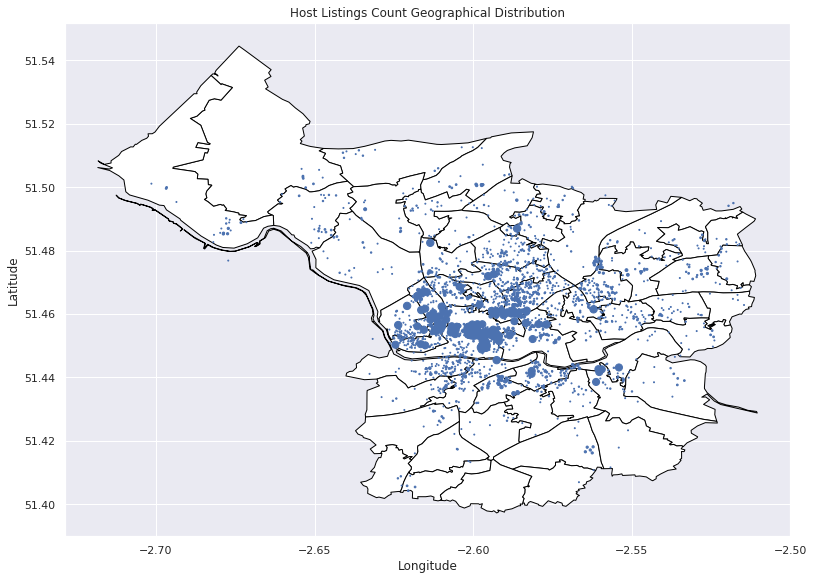

In [43]:
map_plt_2 = map_df.plot(color='white', edgecolor='black', figsize=(13,13))
sct = plt.scatter(df.longitude, df.latitude, s=df.calculated_host_listings_count, alpha=1)
xlab = plt.xlabel("Longitude")
ylab = plt.ylabel("Latitude")
tit = plt.title("Host Listings Count Geographical Distribution")

## Data Preparation
Before preparing the data, the classifiers must be chosen, as different classifiers will require different types of preparation. 
Since one of the goals of the notebook is to be able to extract important features from the classification, a decision tree classifier was one of the classifiers selected. Choosing a decision tree classifier also means that there is less data cleansing to be done. Decision trees are not sensitive to outliers, and they also do not require the data to be scaled or normalised. Another reason to choose a decision tree is that nonlinear relationships between features do not affect the classifier. This could be the case for this problem.

Another chosen classifier is Random Forests, as it builds on decision trees. It fits a uses several decision tree classifiers on different sub-samples of the dataset and uses averaging to improve the accuracy and decrease the chances of overfitting, as decision trees often do.

A Bagging classifier, AdaBoost classifier and Voting classifier are also used, to try and improve scores through ensemble techniques.

What decision trees and the other classifiers require in terms of data preparation is for categorical features to be One Hot Encoded, or Label Encoded. The first technique is used for the neighbourhood column (the only categorical column left), while for the target variable (is_house) nothing is required, as it is already in a binary format.

In [44]:
neigh_dummies = pd.get_dummies(df.neighbourhood, prefix="neighbourhood")
df = pd.concat([df, neigh_dummies], axis=1)

In [45]:
y = df.is_house
df = df.drop(columns=["neighbourhood", "is_house", "property_type"])

In [46]:
# label_encoder = LabelEncoder()
# y_le = label_encoder.fit_transform(y)

In [47]:
# label_binarizer = LabelBinarizer()
# y_lb = label_binarizer.fit_transform(y)

In [48]:
x = df
# y = y_le           # label encoded
# y = y_lb           # label binarised

The data set is split in train and test sets, with stratified K fold Cross validation being performed, which preserves the distribution of samples for each class, in each fold.

A copy of the longitude and latitude columns is made for later plotting purposes. The columns are removed because they provide no benefit for the classification.

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=42)

x_test_lat = x_test.latitude.copy()
x_test_lon = x_test.longitude.copy()

x_train = x_train.drop(columns=["longitude", "latitude"])
x_test = x_test.drop(columns=["longitude", "latitude"])
x = x.drop(columns=["longitude", "latitude"])

The following are the features kept for classifying whether a listing is a 'house' or not.

In [50]:
x_test.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'availability_365', 'entire_home_yes', 'neighbourhood_Ashley',
       'neighbourhood_Avonmouth & Lawrence Weston', 'neighbourhood_Bedminster',
       'neighbourhood_Bishopston & Ashley Down', 'neighbourhood_Bishopsworth',
       'neighbourhood_Brislington East', 'neighbourhood_Brislington West',
       'neighbourhood_Central', 'neighbourhood_Clifton',
       'neighbourhood_Clifton Down', 'neighbourhood_Cotham',
       'neighbourhood_Easton', 'neighbourhood_Eastville',
       'neighbourhood_Filwood', 'neighbourhood_Frome Vale',
       'neighbourhood_Hartcliffe & Withywood',
       'neighbourhood_Henbury & Bre

The shape of the train and test sets is printed. The scoring metrics are also listed so they are passed in to each classifier.

In [51]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
scoring = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall', 'roc_auc']

(1731, 52) (1731,)
(578, 52) (578,)


In [52]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Decision Tree Classifier
### Grid Search Cross Validation
A good way to find optimal parameters for classifiers with several parameters that largely affect scores, grid search cross validation can be used. It performs an exhaustive search over specified parameter values for any estimator chosen, and will return the best parameters for a given objective (score), after performing a grid search over a parameter grid.

Some reasonable ranges for the three main parameters for decision tree classifiers are listed below and passed to the grid search.

In [53]:
dt_param_grid = {
    "min_samples_split": np.arange(10, 500, 20),
    "max_depth": np.arange(1, 25, 2),
    "max_features": np.arange(3, 27, 2)
}

dt_scorers = {
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "accuracy": make_scorer(accuracy_score)
}

In [54]:
def dt_gs(refit_score='precision'):
    skf = StratifiedKFold(n_splits=10)
    dt_clf = DecisionTreeClassifier(random_state=42)
    gs_tree = GridSearchCV(dt_clf, dt_param_grid, scoring=dt_scorers,
                           refit=refit_score, cv=skf, return_train_score=True, n_jobs=-1)
    gs_tree.fit(x, y)
    y_pred = gs_tree.predict(x)
    print('Best params for {}'.format(refit_score))
    print(gs_tree.best_params_)
    return gs_tree

In [55]:
# gs_tree = dt_gs(refit_score='precision')
# gs_tree.best_score_

### Decision Tree Classifier with fine-tuned parameters
The best parameters chosen are then used for the decision classifier to predict the target values.
The scores are then printed.

In [56]:
tree_clf = DecisionTreeClassifier(max_depth=7, max_features=50, random_state=42)
dt_class = tree_clf.fit(x_train, y_train)
y_pred_dt = tree_clf.predict(x_test)
y_scores_dt = tree_clf.predict_proba(x_test)
print(tree_clf.__class__.__name__, "Accuracy Score: ", accuracy_score(y_test, y_pred_dt))
print(tree_clf.__class__.__name__, "Balanced Accuracy Score: ", balanced_accuracy_score(y_test, y_pred_dt))
print(tree_clf.__class__.__name__, "F1 Score: ", f1_score(y_test, y_pred_dt))
print(tree_clf.__class__.__name__, "Precision Score: ", precision_score(y_test, y_pred_dt))
print(tree_clf.__class__.__name__, "Recall Score: ", recall_score(y_test, y_pred_dt))
print(tree_clf.__class__.__name__, "ROC AUC Score: ", roc_auc_score(y_test, y_scores_dt[:, 1]))

DecisionTreeClassifier Accuracy Score:  0.7854671280276817
DecisionTreeClassifier Balanced Accuracy Score:  0.7882566994409099
DecisionTreeClassifier F1 Score:  0.7793594306049823
DecisionTreeClassifier Precision Score:  0.7398648648648649
DecisionTreeClassifier Recall Score:  0.8233082706766918
DecisionTreeClassifier ROC AUC Score:  0.8235070850202428


### K folds Cross Validation
K folds cross validation is performed to get an even better idea of the strength of the classifier. 10 folds are selected, and the results for each score are averaged and printed. The results are slightly lower than the single run, but still acceptable.

In [57]:
dt_scores = cross_validate(tree_clf, x, y, scoring=scoring, cv=10, n_jobs=-1, return_train_score=False)
print(tree_clf.__class__.__name__, "Accuracy Score: ", np.mean(dt_scores['test_accuracy']))
print(tree_clf.__class__.__name__, "Balanced Accuracy Score: ", np.mean(dt_scores['test_balanced_accuracy']))
print(tree_clf.__class__.__name__, "F1 Score: ", np.mean(dt_scores['test_f1']))
print(tree_clf.__class__.__name__, "Precision Score: ", np.mean(dt_scores['test_precision']))
print(tree_clf.__class__.__name__, "Recall Score: ", np.mean(dt_scores['test_recall']))
print(tree_clf.__class__.__name__, "ROC AUC Score: ", np.mean(dt_scores['test_roc_auc']))

DecisionTreeClassifier Accuracy Score:  0.7757368880494819
DecisionTreeClassifier Balanced Accuracy Score:  0.7774263701571664
DecisionTreeClassifier F1 Score:  0.76694464514534
DecisionTreeClassifier Precision Score:  0.7407966844689815
DecisionTreeClassifier Recall Score:  0.7988979016046552
DecisionTreeClassifier ROC AUC Score:  0.8055603179162804


### Confusion Matrix
The confusion matrix for the decision tree classifier shows that it found it easier to classify houses than "Not a House". This makes sense as for the outer neighbourhoods with fewer listings, it is harder for the classifier to tell whether it's a house or not.

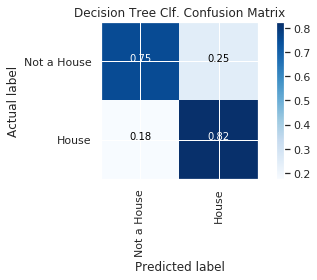

In [58]:
dt_cnf_matrix = confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(dt_cnf_matrix, classes=["Not a House", "House"],
                      title='Decision Tree Clf. Confusion Matrix')

### Plot Decision Tree
The actual decision tree can be seen in the plot below, where the index of X indicates the column number, using the same index as x_test.columns.

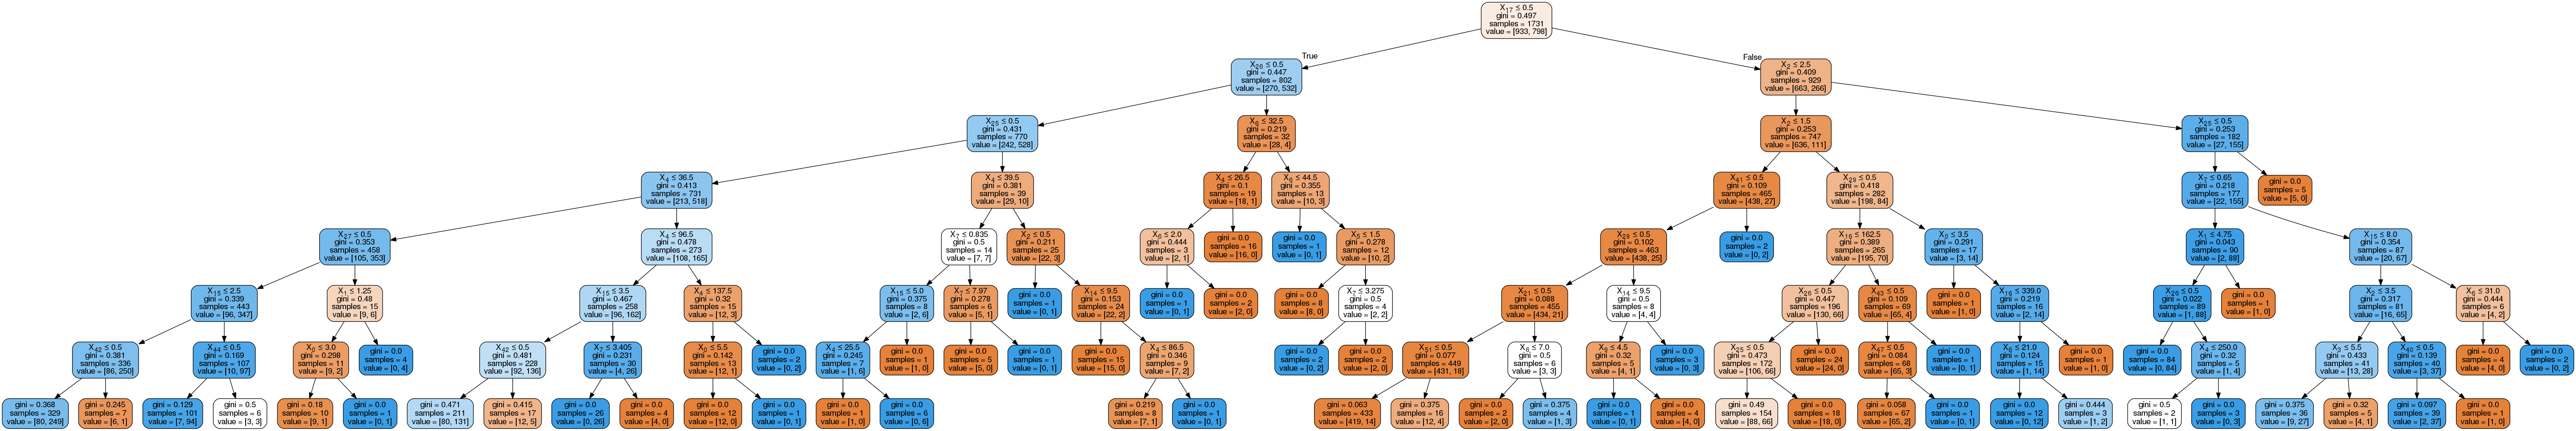

In [59]:
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Random Forests
### Grid Search Cross Validation
Random Forests is one of the most accurate machine algorithms available. In order to optimise the parameters, grid search is performed. 

In [60]:
rf_param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_leaf_nodes' : [3, 5, 15, 25],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

rf_scorers = {
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "accuracy": make_scorer(accuracy_score)
}

In [61]:
def rf_gs(refit_score='precision'):
    skf = StratifiedKFold(n_splits=10)
    rf_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
    gs_rf = GridSearchCV(rf_clf, rf_param_grid, scoring = rf_scorers,
                         refit=refit_score, cv=skf, return_train_score=True, n_jobs=-1)
    gs_rf.fit(x, y)
    y_pred = gs_rf.predict(x)
    print('Best params for {}'.format(refit_score))
    print(gs_rf.best_params_)
    return gs_rf

In [62]:
# gs_rand_forest = rf_gs()
# gs_rand_forest.best_score_

### Random Forests with fine-tuned parameters
The best parameters are then used, and the scores printed. As expected, they all represent an improvement compared to the decision tree classifier.

In [63]:
rf_clf = RandomForestClassifier(
    max_depth=15, max_features=10, n_estimators=120, n_jobs=-1, random_state=42
)
rf_model = rf_clf.fit(x_train, y_train)
y_pred_rf = rf_clf.predict(x_test)
y_scores_rf = rf_clf.predict_proba(x_test)
print(rf_clf.__class__.__name__, "Accuracy Score: ", accuracy_score(y_test, y_pred_rf))
print(rf_clf.__class__.__name__, "Balanced Accuracy Score: ", balanced_accuracy_score(y_test, y_pred_rf))
print(rf_clf.__class__.__name__, "F1 Score: ", f1_score(y_test, y_pred_rf))
print(rf_clf.__class__.__name__, "Precision Score: ", precision_score(y_test, y_pred_rf))
print(rf_clf.__class__.__name__, "Recall Score: ", recall_score(y_test, y_pred_rf))
print(rf_clf.__class__.__name__, "ROC AUC Score: ", roc_auc_score(y_test, y_scores_rf[:, 1]))

RandomForestClassifier Accuracy Score:  0.8096885813148789
RandomForestClassifier Balanced Accuracy Score:  0.8112468671679198
RandomForestClassifier F1 Score:  0.8007246376811594
RandomForestClassifier Precision Score:  0.7727272727272727
RandomForestClassifier Recall Score:  0.8308270676691729
RandomForestClassifier ROC AUC Score:  0.882964623096202


### K folds Cross Validation
K folds cross validation is then performed, and the scores averaged.

In [64]:
rf_scores = cross_validate(rf_clf, x, y, scoring=scoring, cv=10, n_jobs=-1, return_train_score=False)
print(rf_clf.__class__.__name__, "Accuracy Score: ", np.mean(rf_scores['test_accuracy']))
print(rf_clf.__class__.__name__, "Balanced Accuracy Score: ", np.mean(rf_scores['test_balanced_accuracy']))
print(rf_clf.__class__.__name__, "F1 Score: ", np.mean(rf_scores['test_f1']))
print(rf_clf.__class__.__name__, "Precision Score: ", np.mean(rf_scores['test_precision']))
print(rf_clf.__class__.__name__, "Recall Score: ", np.mean(rf_scores['test_recall']))
print(rf_clf.__class__.__name__, "ROC AUC Score: ", np.mean(rf_scores['test_roc_auc']))

RandomForestClassifier Accuracy Score:  0.8046854657087043
RandomForestClassifier Balanced Accuracy Score:  0.8064456618563035
RandomForestClassifier F1 Score:  0.7962390422757213
RandomForestClassifier Precision Score:  0.7709701097926722
RandomForestClassifier Recall Score:  0.8288397108093809
RandomForestClassifier ROC AUC Score:  0.8850890017690457


### Confusion Matrix
The confusion matrix confirms the higher scores, with both higher precision and recall. 

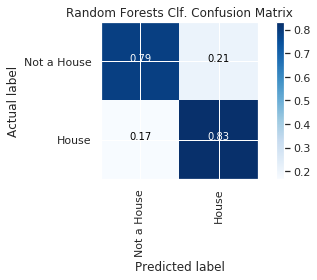

In [65]:
rf_cnf_matrix = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(rf_cnf_matrix, classes=["Not a House", "House"],
                      title='Random Forests Clf. Confusion Matrix')

### Plot Random Forest Feature Importances
The following plot shows the feature importances for the random forest classifier. From this plot we can get an idea of what influences the classifier into making a classification. Suprisingly, price is a large indicator of whether the listing is a house or not. The relationship between price and is_house has been observed already, and this plot proves that price aids the classifier in its prediction. The price is higher for central neighbourhoods, which also have a low amount of houses. From here the classifier makes its prediction.
The relationship between entire_home_yes and is_house had also been already observed. For apartments, hosts are more likely to leave the place for the guests entirely.
More features which were expected for being important for classifying are the central neighbourhoods: Central and Clifton, as these are very likely to not have many houses.

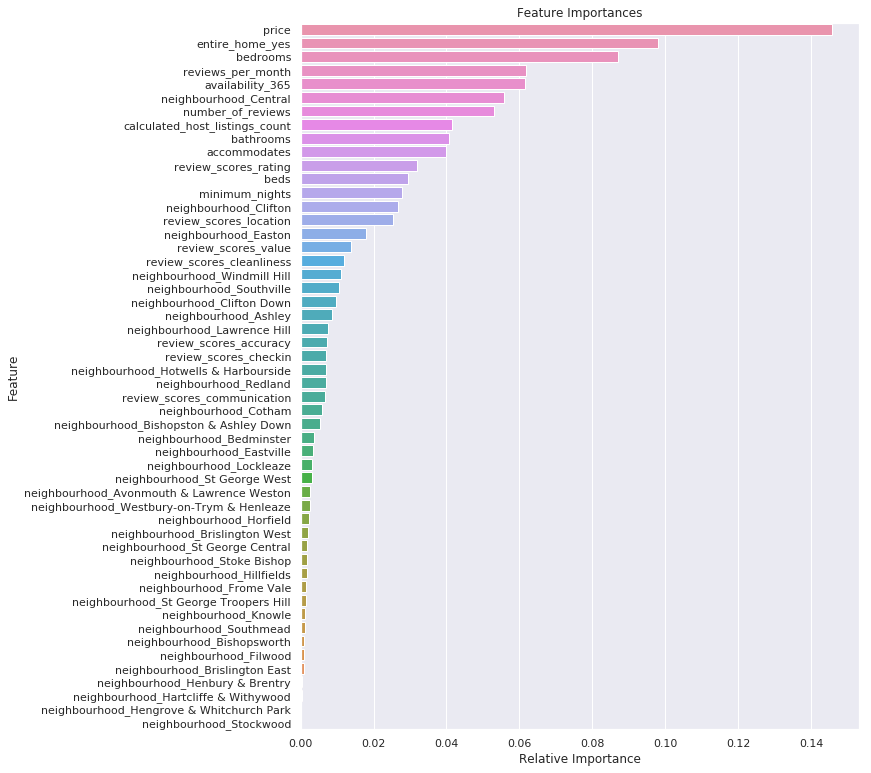

In [66]:
features = x_test.columns
importances = rf_clf.feature_importances_
indices = np.argsort(importances)

fig = plt.figure(figsize=(10,13))
tit = plt.title('Feature Importances')
bar = sns.barplot(importances[indices], [features[i] for i in indices])
plt.gca().invert_yaxis()
xl = plt.xlabel('Relative Importance')
yl = plt.ylabel('Feature')

## Bagging Classifier
Bagging classifiers are an ensemble meta-estimator that fit base classifiers each on random subsets of the original dataset and then aggregate their individual predictions to make predictions. They are often used with decision trees, as in this case. The parameters were chosen after several runs with trial and error.

In [67]:
bag_clf = BaggingClassifier(
    tree_clf, n_estimators=600,
    max_samples=0.2, bootstrap=True, n_jobs=-1, oob_score=True, random_state=42
)
model_bag = bag_clf.fit(x_train, y_train)
y_pred_bag = bag_clf.predict(x_test)
y_scores_bag = bag_clf.predict_proba(x_test)
print(bag_clf.__class__.__name__, "Accuracy Score: ", accuracy_score(y_test, y_pred_bag))
print(bag_clf.__class__.__name__, "Balanced Accuracy Score: ", balanced_accuracy_score(y_test, y_pred_bag))
print(bag_clf.__class__.__name__, "F1 Score: ", f1_score(y_test, y_pred_bag))
print(bag_clf.__class__.__name__, "Precision Score: ", precision_score(y_test, y_pred_bag))
print(bag_clf.__class__.__name__, "Recall Score: ", recall_score(y_test, y_pred_bag))
print(bag_clf.__class__.__name__, "ROC AUC Score: ", roc_auc_score(y_test, y_scores_bag[:, 1]))
print(bag_clf.__class__.__name__, "OOB Score: ", bag_clf.oob_score_)

BaggingClassifier Accuracy Score:  0.7993079584775087
BaggingClassifier Balanced Accuracy Score:  0.8024628879892037
BaggingClassifier F1 Score:  0.7943262411347517
BaggingClassifier Precision Score:  0.7516778523489933
BaggingClassifier Recall Score:  0.8421052631578947
BaggingClassifier ROC AUC Score:  0.8762169847696164
BaggingClassifier OOB Score:  0.7960716348931254


### K folds Cross Validation
The scores are good, as the Bagging classifier performed better than the decision tree it has been passed.

In [68]:
bag_scores = cross_validate(bag_clf, x, y, scoring=scoring, cv=10, n_jobs=-1, return_train_score=False)
print(bag_clf.__class__.__name__, "Accuracy Score: ", np.mean(bag_scores['test_accuracy']))
print(bag_clf.__class__.__name__, "Balanced Accuracy Score: ", np.mean(bag_scores['test_balanced_accuracy']))
print(bag_clf.__class__.__name__, "F1 Score: ", np.mean(bag_scores['test_f1']))
print(bag_clf.__class__.__name__, "Precision Score: ", np.mean(bag_scores['test_precision']))
print(bag_clf.__class__.__name__, "Recall Score: ", np.mean(bag_scores['test_recall']))
print(bag_clf.__class__.__name__, "ROC AUC Score: ", np.mean(bag_scores['test_roc_auc']))

BaggingClassifier Accuracy Score:  0.7930157161678901
BaggingClassifier Balanced Accuracy Score:  0.7949425498148475
BaggingClassifier F1 Score:  0.7851729737553278
BaggingClassifier Precision Score:  0.7572337111996397
BaggingClassifier Recall Score:  0.819485099629695
BaggingClassifier ROC AUC Score:  0.8799373410845217


### Confusion Matrix

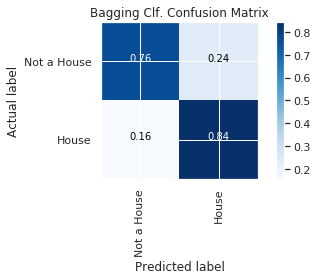

In [69]:
bag_cnf_matrix = confusion_matrix(y_test, y_pred_bag)
plot_confusion_matrix(bag_cnf_matrix, classes=["Not a House", "House"], title='Bagging Clf. Confusion Matrix')

## AdaBoost Classifier
AdaBoost classifiers are a meta-estimator that fit a classifier on the original dataset and then fits additional copies of the classifier on the same dataset, correcting the weights of incorrectly predicted values. The parameters selected returned the highest scores.

In [70]:
abc = AdaBoostClassifier(n_estimators=500, base_estimator=tree_clf,
                     learning_rate=0.00007, random_state=42)
abc_model = abc.fit(x_train, y_train)
y_scores_abc = abc.predict_proba(x_test)
y_pred_abc = abc_model.predict(x_test)

print(abc.__class__.__name__, "Accuracy Score: ", accuracy_score(y_test, y_pred_abc))
print(abc.__class__.__name__, "Balanced Accuracy Score: ", balanced_accuracy_score(y_test, y_pred_abc))
print(abc.__class__.__name__, "F1 Score: ", f1_score(y_test, y_pred_abc))
print(abc.__class__.__name__, "Precision Score: ", precision_score(y_test, y_pred_abc))
print(abc.__class__.__name__, "Recall Score: ", recall_score(y_test, y_pred_abc))
print(abc.__class__.__name__, "ROC AUC Score: ", roc_auc_score(y_test, y_scores_abc[:, 1]))

AdaBoostClassifier Accuracy Score:  0.7889273356401384
AdaBoostClassifier Balanced Accuracy Score:  0.7931246385193753
AdaBoostClassifier F1 Score:  0.7867132867132868
AdaBoostClassifier Precision Score:  0.7352941176470589
AdaBoostClassifier Recall Score:  0.8458646616541353
AdaBoostClassifier ROC AUC Score:  0.8119457297088877


### K folds Cross Validation
The scores for the AdaBoost classifier seem to be lower than Random Forests and the Bagging classifier. Possibly more parameter tuning could be performed. 

In [71]:
abc_scores = cross_validate(abc, x, y, scoring=scoring, cv=10, n_jobs=-1, return_train_score=False)
print(abc.__class__.__name__, "Accuracy Score: ", np.mean(abc_scores['test_accuracy']))
print(abc.__class__.__name__, "Balanced Accuracy Score: ", np.mean(abc_scores['test_balanced_accuracy']))
print(abc.__class__.__name__, "F1 Score: ", np.mean(abc_scores['test_f1']))
print(abc.__class__.__name__, "Precision Score: ", np.mean(abc_scores['test_precision']))
print(abc.__class__.__name__, "Recall Score: ", np.mean(abc_scores['test_recall']))
print(abc.__class__.__name__, "ROC AUC Score: ", np.mean(abc_scores['test_roc_auc']))

AdaBoostClassifier Accuracy Score:  0.7722511471536959
AdaBoostClassifier Balanced Accuracy Score:  0.7745934420168259
AdaBoostClassifier F1 Score:  0.7652732335185577
AdaBoostClassifier Precision Score:  0.7331042643963442
AdaBoostClassifier Recall Score:  0.8044965614530065
AdaBoostClassifier ROC AUC Score:  0.8089880566663444


### Confusion Matrix

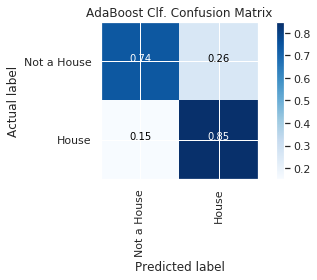

In [72]:
abc_cnf_matrix = confusion_matrix(y_test, y_pred_abc)
plot_confusion_matrix(abc_cnf_matrix, classes=["Not a House", "House"], title='AdaBoost Clf. Confusion Matrix')

## Voting Classifier

A voting classifier was selected to find out whether higher scores could be gained by aggregating the previous four classifiers. Soft voting is used.

In [73]:
voting_clf = VotingClassifier(estimators=[('dt', tree_clf), ('rf', rf_clf), ('bag', bag_clf), ('abc', abc)],
                              voting='soft')
vot_model = voting_clf.fit(x_train, y_train)
y_pred_vot = voting_clf.predict(x_test)
y_scores_vot = voting_clf.predict_proba(x_test)

print(voting_clf.__class__.__name__, "Accuracy Score: ", accuracy_score(y_test, y_pred_vot))
print(voting_clf.__class__.__name__, "Balanced Accuracy Score: ", balanced_accuracy_score(y_test, y_pred_vot))
print(voting_clf.__class__.__name__, "F1 Score: ", f1_score(y_test, y_pred_vot))
print(voting_clf.__class__.__name__, "Precision Score: ", precision_score(y_test, y_pred_vot))
print(voting_clf.__class__.__name__, "Recall Score: ", recall_score(y_test, y_pred_vot))
print(voting_clf.__class__.__name__, "ROC AUC Score: ", roc_auc_score(y_test, y_scores_vot[:, 1]))

VotingClassifier Accuracy Score:  0.801038062283737
VotingClassifier Balanced Accuracy Score:  0.8037883169462117
VotingClassifier F1 Score:  0.7950089126559715
VotingClassifier Precision Score:  0.7559322033898305
VotingClassifier Recall Score:  0.8383458646616542
VotingClassifier ROC AUC Score:  0.8719394640447271


### K folds Cross Validation
The scores are high, although the Random Forests classifier seems to have outperformed all other four.

In [74]:
vot_scores = cross_validate(voting_clf, x, y, scoring=scoring, cv=10, n_jobs=-1, return_train_score=False)
print(voting_clf.__class__.__name__, "Accuracy Score: ", np.mean(vot_scores['test_accuracy']))
print(voting_clf.__class__.__name__, "Balanced Accuracy Score: ", np.mean(vot_scores['test_balanced_accuracy']))
print(voting_clf.__class__.__name__, "F1 Score: ", np.mean(vot_scores['test_f1']))
print(voting_clf.__class__.__name__, "Precision Score: ", np.mean(vot_scores['test_precision']))
print(voting_clf.__class__.__name__, "Recall Score: ", np.mean(vot_scores['test_recall']))
print(voting_clf.__class__.__name__, "ROC AUC Score: ", np.mean(vot_scores['test_roc_auc']))

VotingClassifier Accuracy Score:  0.7848166663421537
VotingClassifier Balanced Accuracy Score:  0.7864536976467711
VotingClassifier F1 Score:  0.7759940487345226
VotingClassifier Precision Score:  0.7499594375157097
VotingClassifier Recall Score:  0.8073267501322519
VotingClassifier ROC AUC Score:  0.8734588870370477


### Confusion Matrix

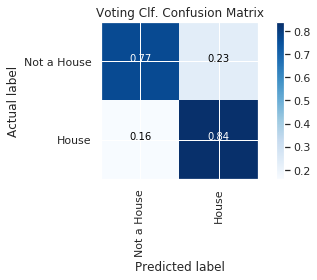

In [75]:
vot_cnf_matrix = confusion_matrix(y_test, y_pred_vot)
plot_confusion_matrix(vot_cnf_matrix, classes=["Not a House", "House"], title='Voting Clf. Confusion Matrix')

## Plot Results from Metrics
The Random forests classifier is chosen for plotting several useful classification metrics.

In [76]:
def plot_prec_recall_curve(precision, recall, thresholds):
    fig = plt.figure(figsize=(8,8))
    title = plt.title("Precision and Recall curve, ^ = current threshold")
    step = plt.step(recall, prec, color='b', alpha=0.2, where='post')
    fill = plt.fill_between(recall, prec, step='post', alpha=0.4, color='b')
    xlim = plt.ylim([0.1, 1.01]);
    ylim = plt.xlim([0.1, 1.01]);
    xla = plt.xlabel('Recall');
    yla = plt.ylabel('Precision');  
    m = np.argmin(np.abs(thresholds - 0.5))
    pr_plt = plt.plot(recall[m], prec[m], '^', c='k', markersize=15)
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

### Precision and Recall Curve
The precision-recall curve shows the tradeoff between precision and recall for different thresholds. The Random forest classifier seems to have a smooth curve with a good balanced. Only a slight "bump" is seen at 0.2, 0.9. 

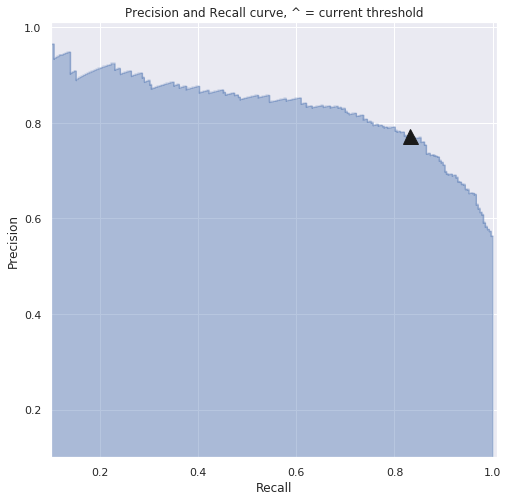

In [77]:
prec, recall, thresholds = precision_recall_curve(y_test, y_scores_rf[:, 1])
plot_prec_recall_curve(prec, recall, thresholds)

### Precision and Recall vs Threshold

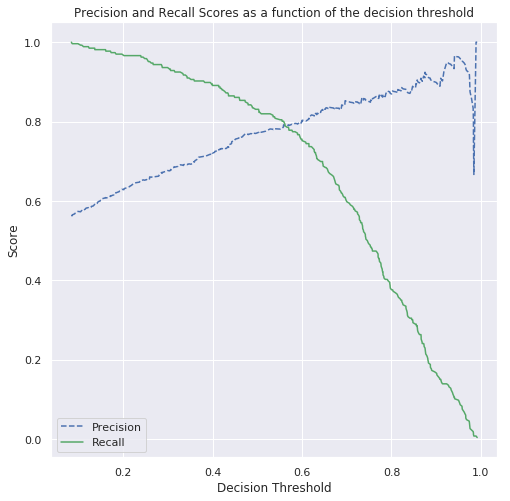

In [78]:
plot_precision_recall_vs_threshold(prec, recall, thresholds)

### ROC Curve Classifier Comparison
An ideal ROC curve would cover the top left corner of the plot, with a false positive rate of zero, and a true positive rate of one. The area under the curve (AUC) should ideally be as large as possible. The following plot shows the difference between the classifers. It is clear that Random Forests has the largest AUC, along with the Bagging Classifier.

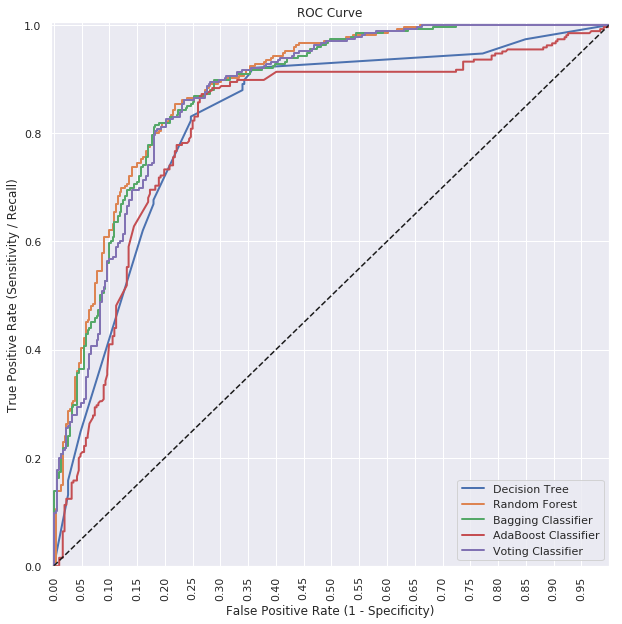

In [79]:
fpr_dt, tpr_dt, auc_thresholds_dt = roc_curve(y_test, y_scores_dt[:, 1])
fpr_rf, tpr_rf, auc_thresholds_rf = roc_curve(y_test, y_scores_rf[:, 1])
fpr_bag, tpr_bag, auc_thresholds_bag = roc_curve(y_test, y_scores_bag[:, 1])
fpr_abc, tpr_abc, auc_thresholds_abc = roc_curve(y_test, y_scores_abc[:, 1])
fpr_vot, tpr_vot, auc_thresholds_vot = roc_curve(y_test, y_scores_vot[:, 1])

fig = plt.figure(figsize=(10,10))
tit = plt.title('ROC Curve')
dt_plt = plt.plot(fpr_dt, tpr_dt, linewidth=2, label="Decision Tree")
rf_plt = plt.plot(fpr_rf, tpr_rf, linewidth=2, label="Random Forest")
bag_plt = plt.plot(fpr_bag, tpr_bag, linewidth=2, label="Bagging Classifier")
abc_plt = plt.plot(fpr_abc, tpr_abc, linewidth=2, label="AdaBoost Classifier")
vot_plt = plt.plot(fpr_vot, tpr_vot, linewidth=2, label="Voting Classifier")
lims = plt.plot([0, 1], [0, 1], 'k--')
ax = plt.axis([-0.005, 1, 0, 1.005])
xt = plt.xticks(np.arange(0,1, 0.05), rotation=90)
xlab = plt.xlabel("False Positive Rate (1 - Specificity)")
ylab = plt.ylabel("True Positive Rate (Sensitivity / Recall)")
leg = plt.legend(loc='best')

## Plot Predictions Vs Actual Values
The following plot shows the predicted values plotted on the map versus the actual values. The resulting purple points are the wrong predictions. Most of them seem to be located in the outer neighbourhoods, which confirms the initial doubts on how the classifier could identify apartments in neighbourhoods where there are not enough listings for it to have a high confidence.

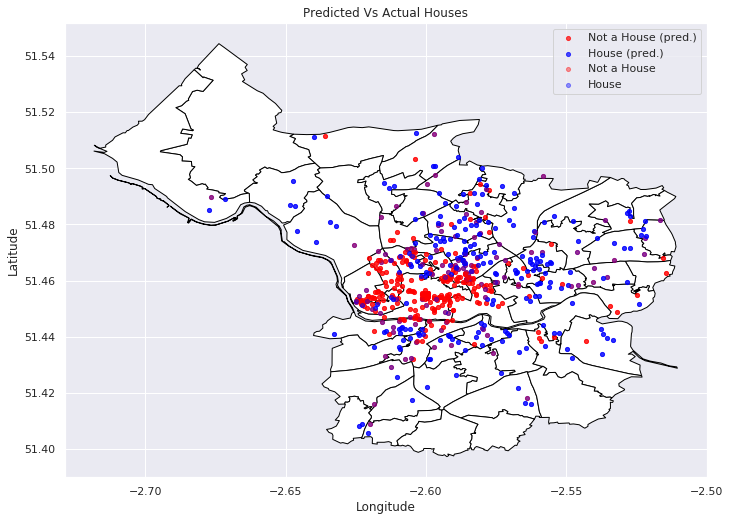

In [80]:
x_test_plot_rf = x_test.copy()
x_test_plot_rf['is_house'] = y_pred_rf
x_test_plot_rf['latitude'] = x_test_lat
x_test_plot_rf['longitude'] = x_test_lon
x_test_plot_rf['is_house_true'] = y_test

fig, ax = plt.subplots(figsize=(11.5,11.5))
ax.set_aspect('equal')
mplot = map_df.plot(ax=ax, color='white', edgecolor='black')
counter = 0
groups1 = x_test_plot_rf.groupby('is_house')
groups2 = x_test_plot_rf.groupby('is_house_true')
for name, group in groups1:
    counter += 1
    if counter == 1:
        sct1 = plt.scatter(group.longitude, group.latitude, s=17, alpha=0.7,
                           label="Not a House (pred.)", c="red")
    else:
        sct2 = plt.scatter(group.longitude, group.latitude, s=17, alpha=0.7, label="House (pred.)", c="blue")
counter = 0
for name, group in groups2:
    counter += 1
    if counter == 1:
        sct3 = plt.scatter(group.longitude, group.latitude, s=17, alpha=0.4, label="Not a House", c="red")
    else:
        sct4 = plt.scatter(group.longitude, group.latitude, s=17, alpha=0.4, label="House", c="blue")
xlab = plt.xlabel("Longitude")
ylab = plt.ylabel("Latitude")
tit = plt.title("Predicted Vs Actual Houses")
leg = ax.legend()

## Conclusion
Overall the classifiers chosen have all managed to achieve F1 scores over 75%, which makes them successful. Random Forests outperformed all other, but still struggled to classify houses in neighbourhoods with low listing count and for which not enough patterns can be drawn.
Importance features were extracted and analysed, and are related to the analyses carried out previously:
- Price is a good indicator, as
- Entire_home is also a useful feature for the classifier, as hosts with houses are less likely to leave them to the guests entirely
- Neighbourhoods, especially the central ones with high listing count, give the classifier an idea on whether the property is a house or not.